In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from cnn import CNN
import torch.nn as nn
import torch.optim as optim

In [2]:
# transformation to the image dataseet:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to a fixed size
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()           # Convert images to PyTorch tensors and scale to [0, 1]
])

In [3]:
train_dir = "data/alzheimer_mri/train"
test_dir = "data/alzheimer_mri/test"

In [4]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)

In [5]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

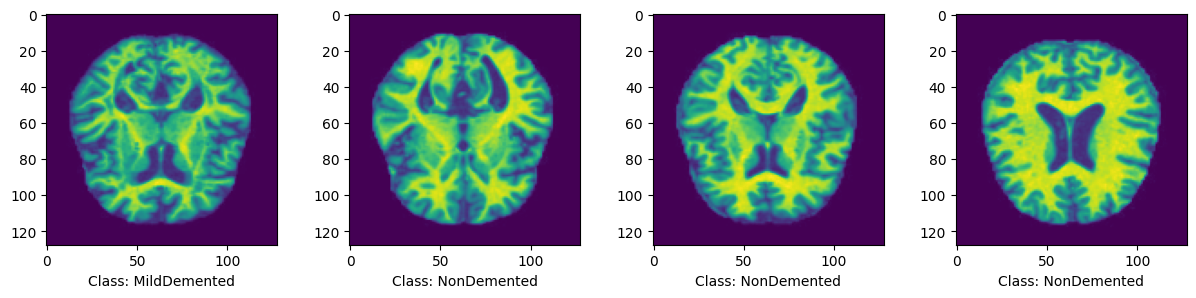

In [6]:
# Get one batch of images
images, labels = next(iter(train_loader))

# Number of images you want to display
num_images = 4

# Create a grid for the images
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

class_names = train_dataset.classes

for i in range(num_images):
    # Convert image tensor to numpy array and transpose the axes
    # PyTorch tensors are in (C, H, W) format, and Matplotlib expects (H, W, C)
    img = images[i].numpy().transpose(1, 2, 0)
    axes[i].imshow(img)
    axes[i].axis('on')  # Turn off axis
    axes[i].set_xlabel(f'Class: {class_names[labels[i].item()]}') # Set the label as x-axis label

plt.show()

In [7]:
# Split the dataset into training and validation sets (80-20 split)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data= torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [8]:
# Create data loaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)

In [9]:
# Initialize the model
model = CNN(
    in_channels=1,
    num_classes=4
)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=16384, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=4, bias=True)
)

In [11]:
import torch.nn.functional as F

best_val_loss = float('inf')
patience = 5  # Number of epochs to wait for improvement before stopping
patience_counter = 0
train_losses = []
val_losses = []
val_accuracies = []
all_preds = []
all_labels = []
num_epochs=10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    model.eval()
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = val_corrects.double() / len(val_loader.dataset)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset counter
        # Optionally save the model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    # Early stopping check
    if patience_counter >= patience:
        print("Stopping early due to no improvement in validation loss.")
        break

Epoch 1/10, Train Loss: 1.0294, Val Loss: 0.9413, Val Accuracy: 0.5560975609756098
Epoch 2/10, Train Loss: 0.8728, Val Loss: 0.8179, Val Accuracy: 0.6282926829268293
Epoch 3/10, Train Loss: 0.7235, Val Loss: 0.6576, Val Accuracy: 0.6946341463414634
Epoch 4/10, Train Loss: 0.4679, Val Loss: 0.3970, Val Accuracy: 0.8341463414634146
Epoch 5/10, Train Loss: 0.2794, Val Loss: 0.2927, Val Accuracy: 0.8878048780487805
Epoch 6/10, Train Loss: 0.1474, Val Loss: 0.2289, Val Accuracy: 0.9151219512195122
Epoch 7/10, Train Loss: 0.1017, Val Loss: 0.2597, Val Accuracy: 0.8878048780487805
Epoch 8/10, Train Loss: 0.0550, Val Loss: 0.1395, Val Accuracy: 0.9424390243902439
Epoch 9/10, Train Loss: 0.0284, Val Loss: 0.0950, Val Accuracy: 0.9717073170731707
Epoch 10/10, Train Loss: 0.0079, Val Loss: 0.0643, Val Accuracy: 0.9795121951219512


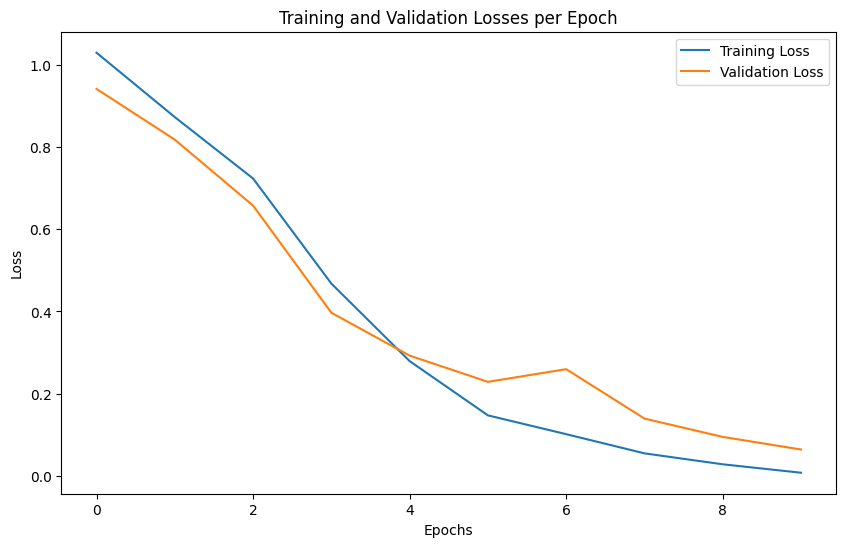

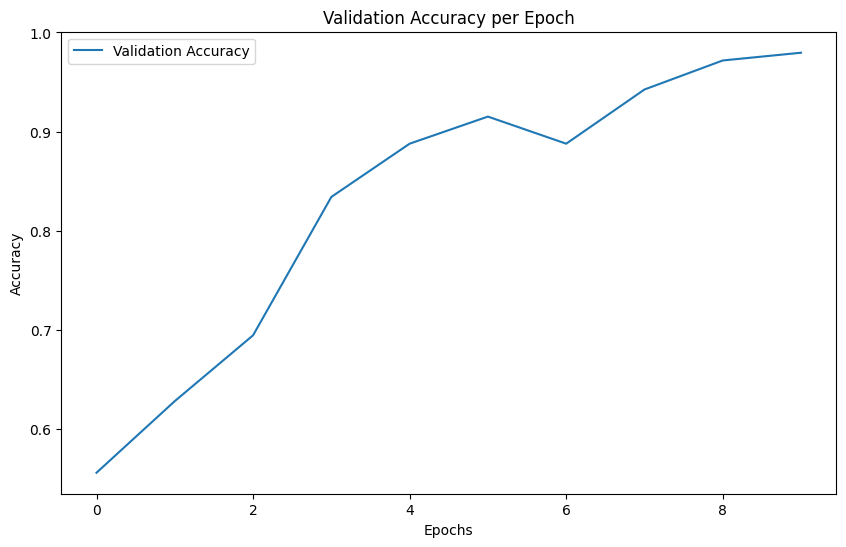

In [12]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Training and Validation Losses per Epoch")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title("Validation Accuracy per Epoch")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

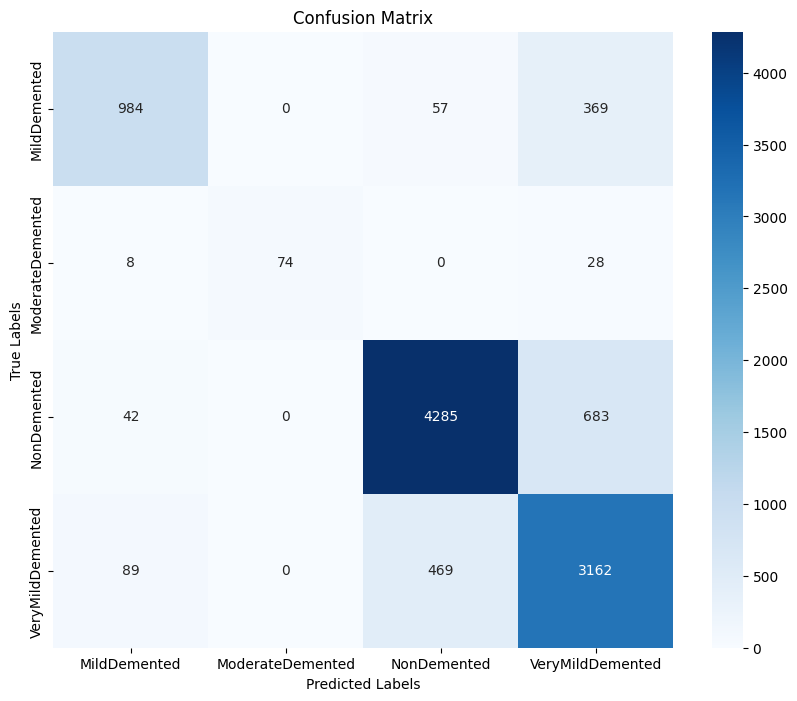

In [13]:
# Calculate the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(all_labels, all_preds)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()